# Topic Modeling of Data Science Job Postings and Northeastern CS Courses 

In [79]:
#imports 
import pandas as pd
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from summa import keywords
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import sys, os
import plotly.graph_objs as go
import plotly.offline as py


In [41]:
#load data from csv
df = pd.read_csv('data_scientist_united_states_job_postings_jobspikr.csv', low_memory = True)

### EDA and Data Wrangling

In [42]:
#drop not needed columns
drop_cols = ['crawl_timestamp', 'salary_offered', 'job_board','geo', 'cursor', 'contact_email', 'contact_phone_number', 'html_job_description', 'inferred_city', 'inferred_state', 'inferred_country']
df = df.drop(columns  = drop_cols)

#drop all rows with any null columns
df = df.dropna(axis = 0, how = 'any', subset = None, inplace = False)


In [43]:
#change the types of the columns from object to necessary type 
df['category'] = df['category'].astype('category')
df['company_name'] = df['company_name'].astype('string')
df['city'] = df['city'].astype('string')
df['state'] = df['state'].astype('string')
df['country'] = df['country'].astype('string')
df['job_type'] = df['job_type'].astype('category')
df['job_description'] = df['job_description'].astype('string')

- We can see below that the types have been changed from object to the necessary types, and all null values have removed and the data in each row is uniform 

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8700 entries, 0 to 9992
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   url              8700 non-null   object  
 1   job_title        8700 non-null   object  
 2   category         8700 non-null   category
 3   company_name     8700 non-null   string  
 4   city             8700 non-null   string  
 5   state            8700 non-null   string  
 6   country          8700 non-null   string  
 7   post_date        8700 non-null   object  
 8   job_description  8700 non-null   string  
 9   job_type         8700 non-null   category
 10  uniq_id          8700 non-null   object  
dtypes: category(2), object(4), string(5)
memory usage: 716.2+ KB


In [45]:
df.head(10)

,url,job_title,category,company_name,city,state,country,post_date,job_description,job_type,uniq_id
0,https://www.indeed.com/viewjob?jk=fd83355c2b23...,Enterprise Data Scientist I,Accounting/Finance,Farmers Insurance Group,Woodland Hills,CA,Usa,2019-02-06,Read what people are saying about working here...,Undefined,3b6c6acfcba6135a31c83bd7ea493b18
3,https://www.indeed.com/viewjob?jk=841edd86ead2...,"Data Scientist, Aladdin Wealth Tech, Associate...",Accounting/Finance,BlackRock,New York,NY 10055 (Midtown area),Usa,2019-02-06,Read what people are saying about working here...,Undefined,1c8541cd2c2c924f9391c7d3f526f64e
4,https://job-openings.monster.com/senior-data-s...,Senior Data Scientist,biotech,CyberCoders,Charlotte,NC,Usa,2019-02-05,We are seeking an extraordinary Data Scientist...,Full Time,445652a560a5441060857853cf267470
5,https://www.indeed.com/viewjob?jk=14fa3772cd5f...,CIB – Fixed Income Research – Machine Learning...,Accounting/Finance,JP Morgan Chase,New York,NY 10179 (Midtown area),Usa,2019-02-05,Read what people are saying about working here...,Undefined,9571ec617ba209fd9a4f842973a4e9c8
6,https://www.indeed.com/viewjob?jk=c6db96b37f8a...,"Data Scientist, Licensing Operations",Accounting/Finance,Spotify,New York,NY 10011 (Chelsea area),Usa,2019-02-06,Read what people are saying about working here...,Undefined,0ec629c03f3e82651711f2626c23cadb
8,https://www.indeed.com/viewjob?jk=0fc298b9f3a8...,"Data Scientist, Aladdin Wealth Tech, Associate",Accounting/Finance,BlackRock,New York,NY 10055 (Midtown area),Usa,2019-02-06,Read what people are saying about working here...,Undefined,80d64b46bc7c89602f63daf06b9f1b4c
10,https://www.indeed.com/viewjob?jk=fe663233109e...,Data Scientist,Computer/Internet,Northrop Grumman,Monterey,CA 93940,Usa,2019-02-06,Read what people are saying about working here...,Undefined,9cd3ed78e5cac9e516ea41173de2c25f
12,https://www.indeed.com/viewjob?jk=27a8eb5fa40b...,ETL Developer / Data Scientist,Computer/Internet,Noblis,Reston,VA 20191,Usa,2019-02-06,Read what people are saying about working here...,Undefined,53224da901548e7137bbb163d456ba6a
13,https://www.indeed.com/viewjob?jk=5d05c5d90a50...,Research Data Scientist,Computer/Internet,ARUP Laboratories,Salt Lake City,UT,Usa,2019-02-06,Read what people are saying about working here...,Undefined,010b5d671896d26eba50948c7c337f94
18,https://www.indeed.com/viewjob?jk=be9a799359df...,Data Scientist,Computer/Internet,Bank of America,Seattle,WA 98104 (First Hill area),Usa,2019-02-06,Read what people are saying about working here...,Undefined,4a8b875d1acc4f560716561d699aa022


# Web Scraping Course information

In [84]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import requests

In [85]:
# open websites
cs_URL = "https://catalog.northeastern.edu/undergraduate/computer-information-science/computer-science/#coursestext"
cs_page = requests.get(cs_URL)

ds_URL = "https://catalog.northeastern.edu/undergraduate/computer-information-science/data-science/#coursestext"
ds_page = requests.get(ds_URL)


In [86]:
soup = BeautifulSoup(cs_page.content, "html.parser")
soup2 = BeautifulSoup(ds_page.content, "html.parser")

In [87]:
# get each course
cs_classes = soup.find_all("div", class_="courseblock")
cs_classes[0]
ds_classes = soup2.find_all("div", class_="courseblock")

In [88]:
# collect data
data = {}
titles = []
descriptions = []
course_nums = []
credits = []
for cl in cs_classes:
    title = cl.find("p", class_ = "courseblocktitle noindent").text.strip()
    desc = cl.find("p", class_ = "cb_desc").text.strip()
    course_num, name, credit = title.split('.')
    titles.append(name)
    course_nums.append(course_num)
    credits.append(credit)
    descriptions.append(desc)
    #data['titles'] = titles
    #data['decriptions'] = descriptions
for cl in ds_classes:
    title = cl.find("p", class_ = "courseblocktitle noindent").text.strip()
    desc = cl.find("p", class_ = "cb_desc").text.strip()
    course_num, name, credit = title.split('.')
    titles.append(name)
    course_nums.append(course_num)
    credits.append(credit)
    descriptions.append(desc)
data['course number'] = course_nums
data['titles'] = titles
data['descriptions'] = descriptions
data['credits'] = credits

In [90]:
df_courses = pd.DataFrame(data)

,course number,titles,descriptions,credits
0,CS 1100,Computer Science and Its Applications,Introduces students to the field of computer s...,(4 Hours)
1,CS 1101,Lab for CS 1100,Accompanies CS 1100. Involves experiments and ...,(1 Hour)
2,CS 1200,First Year Seminar,Seeks to support students in their transition ...,(1 Hour)
3,CS 1210,Professional Development for Khoury Co-op,Continues the preparation of students for care...,(1 Hour)
4,CS 1800,Discrete Structures,Introduces the mathematical structures and met...,(4 Hours)
...,...,...,...,...
127,DS 5020,Introduction to Linear Algebra and Probabili...,Offers an introductory course on the basics of...,(4 Hours)
128,DS 5110,Introduction to Data Management and Processing,Introduces students to the core tasks in data ...,(4 Hours)
129,DS 5220,Supervised Machine Learning and Learning Theory,"Introduces supervised machine learning, which ...",(4 Hours)
130,DS 5230,Unsupervised Machine Learning and Data Mining,Introduces unsupervised machine learning and d...,(4 Hours)


# Create word clouds

In [50]:

os.chdir(sys.path[0])

# Read text 
text = open('data_scientist_united_states_job_postings_jobspikr.csv', mode='r', encoding='utf-8').read()
stopwords = STOPWORDS

wc = WordCloud(
    background_color='white',
    stopwords=stopwords,
    height=200,
    width=400
)

wc.generate(text)

#store to file 
wc.to_file('wordcloud_output_jobs.png')

In [91]:
# Classes Wordcloud
os.chdir(sys.path[0])

# Read text
text = df_courses['descriptions'].sum()
stopwords = STOPWORDS
additional = {'including', 'students', 'Covers', 'offers', 'opportunity'}
stopwords = stopwords.update(additional)

wc = WordCloud(
    background_color='white',
    stopwords=stopwords,
    height=200,
    width=400
)

wc.generate(text)

#store to file
wc.to_file('wordcloud_output_classes.png')

# Document Normalization 

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
corpus = df['job_description']
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(corpus)

In [54]:
import nltk 
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

stop_words.append(['make', 'etc', 'made', 'preferred', 'please'])
lemmatizer = nltk.WordNetLemmatizer()

#Function to pre-process the text information

def normalize_document(doc):
    
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) #re.I (ignore case), re.A (ASCII-only matching)
    doc = doc.lower()
    doc = doc.strip()
    
    # tokenize document
    tokens = wpt.tokenize(doc)
    
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatise document from filtered tokens
    lem_text = [lemmatizer.lemmatize(i) for i in filtered_tokens]
    
    # Remove words that are only one character.
    lem_text = [token for token in lem_text if len(token) > 1]
    
    # Remove numbers, but not words that contain numbers.
    lem_text = [token for token in lem_text if not token.isnumeric()]
    
    doc = ' '.join(lem_text)
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(corpus)

In [55]:
from nltk.tokenize import word_tokenize
import gensim.corpora as corpora
nltk.download('punkt')

#Tokenise the corpus
tokenized_corp = [word_tokenize(i) for i in norm_corpus]

# Create Dictionary
id2word = corpora.Dictionary(tokenized_corp)

#Remove words that don't feature 20 times and those that feature in over 50% of documents
id2word.filter_extremes(no_below=1) #no_above

texts = tokenized_corp

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import pickle
import re
import pyLDAvis
import pyLDAvis.gensim_models

# Hyper Parameter Tuning

In [63]:
import seaborn as sns
num_topics = []
coherences = []
sns.set()
for n in range(1,11):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n, 
                                       random_state=123,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_corp, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    num_topics.append(n)
    coherences.append(coherence_lda)

AttributeError: module 'matplotlib' has no attribute 'plot'

Text(0, 0.5, 'Coherence score')

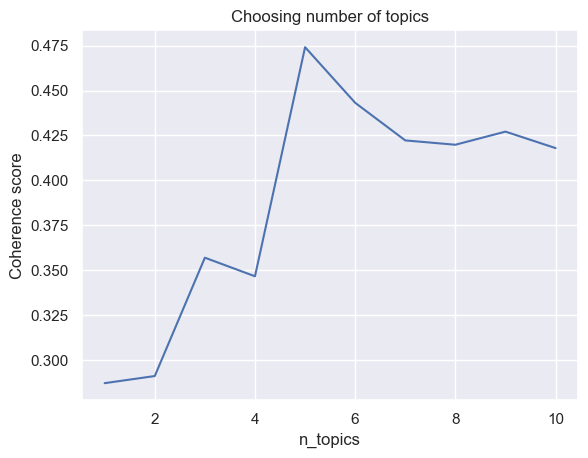

In [66]:
plt.plot(num_topics, coherences)
plt.title('Choosing number of topics')
plt.xlabel('n_topics')
plt.ylabel('Coherence score')

In [69]:
import seaborn as sns
num_topics = []
coherence_s = []
sns.set()
beta = np.arange(0,2,0.1)
for b in beta:
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=123,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       eta = b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_corp, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_s.append(coherence_lda)

Text(0, 0.5, 'Coherence score')

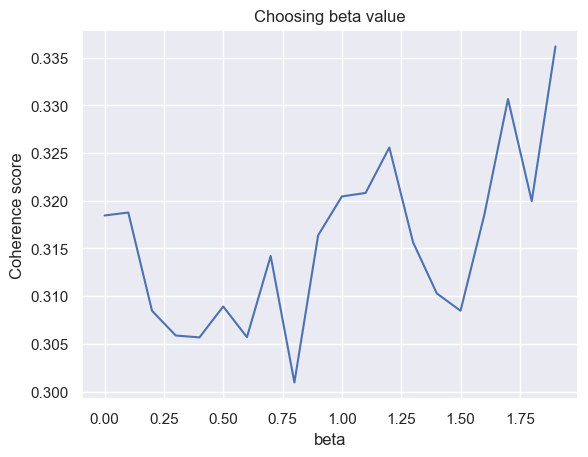

In [70]:
plt.plot(beta, coherence_s)
plt.title('Choosing beta value')
plt.xlabel('beta')
plt.ylabel('Coherence score')

# Model

In [56]:
import gensim
lda_model_jobs = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=123,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       eta = 1.2)

In [57]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"customer" + 0.006*"help" + 0.006*"insight" + 0.006*"people" + '
  '0.005*"build" + 0.005*"role" + 0.004*"building" + 0.004*"research" + '
  '0.004*"deep" + 0.004*"algorithm"'),
 (1,
  '0.019*"aws" + 0.010*"client" + 0.009*"big" + 0.009*"please" + '
  '0.008*"service" + 0.008*"candidate" + 0.008*"azure" + 0.007*"role" + '
  '0.007*"cloud" + 0.007*"customer"'),
 (2,
  '0.015*"client" + 0.007*"service" + 0.007*"system" + 0.006*"security" + '
  '0.006*"world" + 0.005*"career" + 0.005*"professional" + 0.005*"industry" + '
  '0.004*"location" + 0.004*"challenge"'),
 (3,
  '0.012*"--" + 0.011*"set" + 0.010*"ibm" + 0.009*"algorithm" + 0.008*"etc" + '
  '0.007*"customer" + 0.007*"drive" + 0.007*"insight" + 0.006*"qualification" '
  '+ 0.006*"large"'),
 (4,
  '0.009*"use" + 0.008*"training" + 0.007*"intelligence" + 0.007*"youll" + '
  '0.007*"research" + 0.007*"set" + 0.006*"kpmg" + 0.006*"professional" + '
  '0.006*"unstructured" + 0.006*"access"'),
 (5,
  '0.018*"clinical" + 0.0

# Visualization of topics

In [72]:
import importlib
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.089155 -0.038875       1        1  51.350151
2     -0.087752 -0.013754       2        1  35.868899
4     -0.003977  0.104629       3        1   5.740914
1      0.081508 -0.050971       4        1   4.478422
3      0.099376 -0.001029       5        1   2.561614, topic_info=           Term          Freq         Total Category  logprob  loglift
19        build   7069.000000   7069.000000  Default  30.0000  30.0000
580    research  10225.000000  10225.000000  Default  29.0000  29.0000
317      status   6449.000000   6449.000000  Default  28.0000  28.0000
476         big   5112.000000   5112.000000  Default  27.0000  27.0000
165       world   5442.000000   5442.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
442         set    120.107527   5957.617223   Topic5  -6.3192  -0.2395
599     support    118.194193   8769.307420   Topic5  -6.3352  -0.6422
238        help    114.284452   7022.889940   Topic5  -6.3689  -0.4537
196     complex    109.056943   7511.725139   Topic5  -6.4157  -0.5678
220  employment    107.374366   5188.864553   Topic5  -6.4312  -0.2134

[440 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
21537      1  0.950962       &
21537      2  0.015463       &
21537      3  0.007731       &
21537      4  0.015463       &
21537      5  0.007731       &
...      ...       ...     ...
12366      1  0.952010  zillow
12366      2  0.016414  zillow
12366      3  0.008207  zillow
12366      4  0.008207  zillow
12366      5  0.008207  zillow

[1825 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

# Topic Modeling on Khoury Classes

In [ ]:
## Topic Modeling on Khoury Classes
corpus_1 = df_courses['descriptions']
X_train_counts_1 = count_vect.fit_transform(corpus_1)

normalize_corpus = np.vectorize(normalize_document)

norm_corpus_1 = normalize_corpus(corpus_1)

#Tokenise the corpus
tokenized_corp_1 = [word_tokenize(i) for i in norm_corpus_1]

# Create Dictionary
id2word_1 = corpora.Dictionary(tokenized_corp_1)

#Remove words that don't feature 20 times and those that feature in over 50% of documents
id2word_1.filter_extremes(no_below=1) #no_above

texts = tokenized_corp_1

# Term Document Frequency
corpus_1 = [id2word_1.doc2bow(text) for text in texts]

lda_model_1 = gensim.models.LdaMulticore(corpus=corpus_1,
                                       id2word=id2word,
                                       num_topics=5,
                                       random_state=12,
                                       chunksize=1000,
                                       passes=10,
                                       per_word_topics=True,
                                       eta = 1.2)

In [ ]:
# Print the Keyword in the topics
pprint(lda_model_1.print_topics())
doc_lda = lda_model_1[corpus_1]

# Visualization compairing similarities of both models

In [82]:
#Visualization for Comparing LDA Models on Job Postings and Northeastern Courses Dataset
def plot_difference_plotly(mdiff, title="", annotation=None):
    """Plot the difference between models.

    Uses plotly as the backend."""


    annotation_html = None
    if annotation is not None:
        annotation_html = [
            [
                "+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                for (int_tokens, diff_tokens) in row
            ]
            for row in annotation
        ]

    data = go.Heatmap(z=mdiff, colorscale='Turbo', text=annotation_html)
    layout = go.Layout(width=950, height=950, title=title, xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

#visualizaitons
mdiff, annotation = lda_model.diff(lda_model_1, distance='jaccard', num_words=100)
plot_difference_plotly(mdiff, title="Topic difference between LDA Models on Job Postings Data Set and Courses Data Set)[jaccard distance]", annotation=annotation)